In [1]:
import os
import logging as lg
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Set variables for utils
filepathToDirectory = "C:\\Users\\Yannick\\Documents\\Daten\\preprEOC\\"

arrayCalendarParameterID = ["P001", "P002", "P003", "P004", "P005", "P006","P007", "P008", "P009", "P010", "P011", "P012", "P013", "P014", "P015", "P016"]
arrayCyclicParameterID = ["P017", "P018", "P019", "P020", "P021", "P022", "P023", "P024", "P025", "P026", "P027", "P028", "P029", "P030", "P031", "P032", "P033", "P034", "P035", "P036", "P037", "P038", "P039", "P040", "P041", "P042", "P043", "P044", "P045", "P046", "P047", "P048", "P048", "P049", "P050", "P051", "P052", "P053", "P054", "P055", "P056", "P057", "P058", "P059", "P060", "P061", "P062", "P063", "P064"]
arrayProfileParameterID = ["P065", "P066", "P067", "P068","P069", "P070", "P071", "P072", "P073", "P074", "P075", "P076"]

colorPalette = {273.15:"blue",283.15: "green",298.15: "darkorange", 313.15: "red"}
lineStyle = {0.42:":",2.1:"--",3.78:"-.", 4.2:"-"}

In [3]:
#   Erstellt ein Dataframe mit einer Liste von alle Dateien die im Ordner gefunden werden.
#   Für jede Datei werden 'fileName, filePath, SlaveNumber, CellNumber, age_temp, age_soc, parameterId
#   Dataframe beinhaltet noch keine Messdaten

def helper_df_selected_parameters(filesToSearch: list):
    files = os.listdir(filepathToDirectory)
    files = [f for f in files if any(substring in f for substring in filesToSearch)]
    lg.info(f"Found {len(files)} csv files")
    files.sort()
    data = {
        'fileName': [],
        'filePath': [],
        'SlaveNumber': [],
        'CellNumber': [],
        'age_temp': [],
        'age_soc': [],
        "parameterId" : []
    }
    df = pd.DataFrame(data)
    #Fill the dataframe with info of csv files
    for file in files:
        # Extract PXXX
        p_number = re.search(r'P(\d+)', file).group(1)

        # Extract SXX
        s_number = re.search(r'S(\d+)', file).group(1)

        # Extract CXX
        c_number = re.search(r'C(\d+)', file).group(1)

        columns_to_extract = ['age_temp', 'age_soc']
        # Read the specified columns from the CSV file
        temp_df = pd.read_csv(filepathToDirectory+file,usecols=columns_to_extract, delimiter=';', nrows=1)
        age_temp = temp_df['age_temp'].iloc[0]
        age_soc = temp_df['age_soc'].iloc[0]
        file_data = {
            'fileName': file,
            'filePath': filepathToDirectory+file,
            'SlaveNumber': s_number,
            'CellNumber': c_number,
            'age_temp': age_temp,
            'age_soc': age_soc,
            "parameterId" : p_number
        }
        df = pd.concat([df, pd.DataFrame(file_data, index=[0])], ignore_index=True)
    return df

In [4]:
df_cells = helper_df_selected_parameters(arrayCalendarParameterID)
print(df_cells.head())

                      fileName  \
0  cell_eoc_P001_1_S01_C10.csv   
1  cell_eoc_P001_2_S04_C09.csv   
2  cell_eoc_P001_3_S05_C06.csv   
3  cell_eoc_P002_1_S02_C10.csv   
4  cell_eoc_P002_2_S03_C10.csv   

                                            filePath SlaveNumber CellNumber  \
0  C:\Users\Yannick\Documents\Daten\preprEOC\cell...          01         10   
1  C:\Users\Yannick\Documents\Daten\preprEOC\cell...          04         09   
2  C:\Users\Yannick\Documents\Daten\preprEOC\cell...          05         06   
3  C:\Users\Yannick\Documents\Daten\preprEOC\cell...          02         10   
4  C:\Users\Yannick\Documents\Daten\preprEOC\cell...          03         10   

   age_temp  age_soc parameterId  
0       0.0     10.0         001  
1       0.0     10.0         001  
2       0.0     10.0         001  
3       0.0     50.0         002  
4       0.0     50.0         002  


    timestamp_s  timestamp_origin  sd_block_id  cyc_condition  cyc_charged  \
0  1.665626e+09                 1     75906048              2            0   
1  1.666233e+09                 1    229865472              2            0   
2  1.668032e+09                 1    692544000              2            0   
3  1.669851e+09                 1   1160319488              2            0   
4  1.671660e+09                 1   1625245184              2            0   

   age_type  age_temp  age_soc  age_chg_rate  age_dischg_rate  ...  \
0         1         0       10           0.0              0.0  ...   
1         1         0       10           0.0              0.0  ...   
2         1         0       10           0.0              0.0  ...   
3         1         0       10           0.0              0.0  ...   
4         1         0       10           0.0              0.0  ...   

   num_cycles_checkup  total_q_condition_Ah  total_q_chg_Ah  \
0                   1                2.9412    

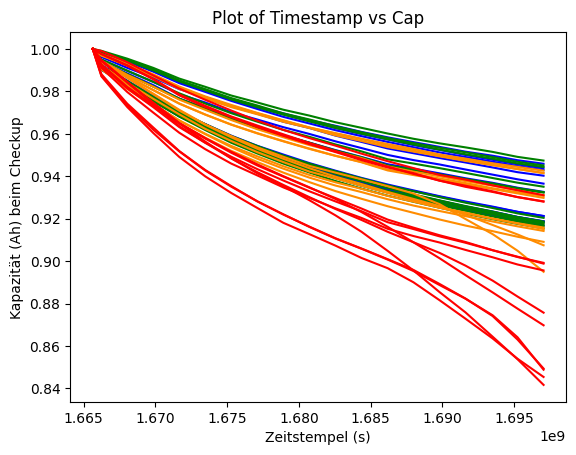

In [5]:
df_cells = helper_df_selected_parameters(arrayCalendarParameterID)
df_cell_csv_content = pd.DataFrame()

for index,row in df_cells.iterrows():
        df_temp = pd.read_csv(row["filePath"], sep=";", header=0)
        df_temp = df_temp[(df_temp['cyc_charged'] == 0) & (df_temp['cyc_condition'] == 2) & (df_temp['cyc_condition'] == 2)]
        df_temp.loc[:, 'cap_aged_est_Ah'] = df_temp['cap_aged_est_Ah'] / df_temp['cap_aged_est_Ah'].iloc[0]
        df_temp["fileName"] = row["fileName"]
        df_temp["parameterId"] = row["parameterId"]
        df_cell_csv_content = pd.concat([df_cell_csv_content,df_temp],ignore_index=True)
print(df_cell_csv_content.head())

uniqueFiles= df_cell_csv_content["fileName"].unique()

for file in uniqueFiles:
        df = df_cell_csv_content[df_cell_csv_content["fileName"] == file].reset_index()
        # print(df.head())
        colorInt = df["age_temp"][0] + 273.15
        lineStyleInt = df["age_soc"][0]
        sns.lineplot(data=df, x="timestamp_s", y = "cap_aged_est_Ah", color = colorPalette[colorInt]) #linestyle = lineStyle[lineStyleInt] )
plt.xlabel("Zeitstempel (s)")
plt.ylabel("Kapazität (Ah) beim Checkup")
plt.title("Plot of Timestamp vs Cap")

# Display the plot
plt.show()